  0%|          | 0/13 [00:00<?, ?it/s]

👉 使用 JSON_B 里配置的权重

=== 权重 ===
513880 日经225: 0.4500
513310 中韩半导体: 0.1500
513630 恒生红利低波: 0.4000

=== 指标（A）===
年化收益: 23.93%  夏普: 0.812  最大回撤: -34.44%  平均回撤: -18.25%  CDaR[95%]: -30.38%

=== 指标（B组合）===
年化收益: 42.48%  夏普: 2.066  最大回撤: -11.98%  平均回撤: -1.94%  CDaR[95%]: -8.10%

相关系数（A vs B组合，日收益）：0.5481


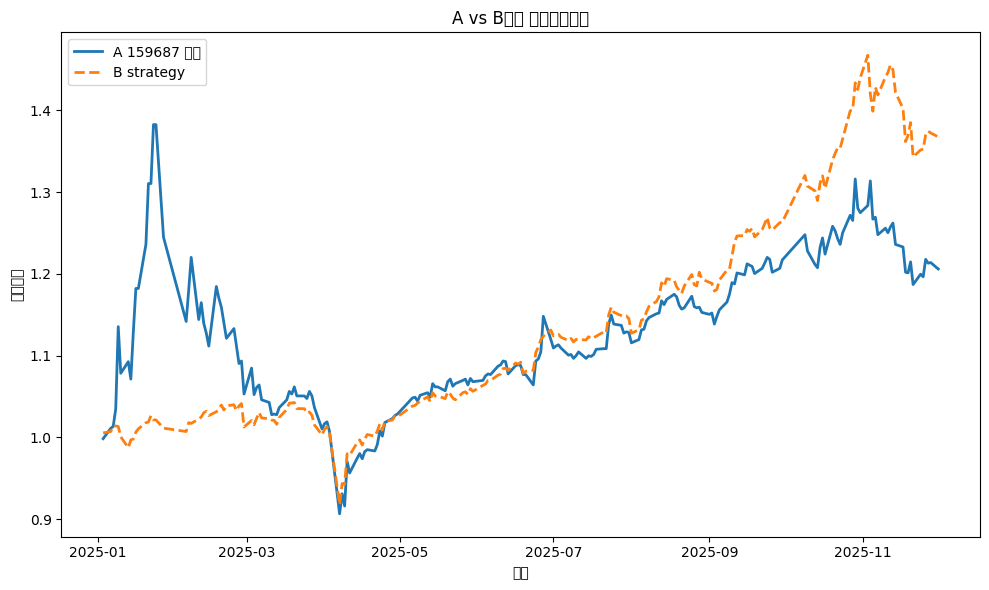


已保存到: ./data/2025-01-01_2025-12-01
- 权重:   ./data/2025-01-01_2025-12-01/weights_159687.csv
- 指标:   ./data/2025-01-01_2025-12-01/metrics_159687.csv
- 曲线:   ./data/2025-01-01_2025-12-01/curves_159687.csv


In [2]:
# -*- coding: utf-8 -*-
# 策略拟合测试（A 用 B 的加权组合去拟合）
# 支持 JSON_B 配置权重（若配置，则直接用这些权重；若未配置，则自动拟合）

import warnings, math, os
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========== 1) 在这里自定义 A/B ==========

# 配置
JSON_A = {"159687": "亚太"}
JSON_B = {
    "513880": {"name": "日经225", "weight": 0.45},
    "513310": {"name": "中韩半导体",   "weight": 0.15},
    "513630": {"name": "恒生红利低波", "weight": 0.4} # 513950
    # "159545": {"name": "恒生红利低波", "weight": 0.4}
}


# # 配置稀土
# JSON_A = {"159687": "亚太"}
# JSON_B = {
#     # 40%
#     "513880": {"name": "日经225", "weight": 0.14},
#     "513730": {"name": "东南亚",   "weight": 0.04},
#     "513310": {"name": "中韩半导体",   "weight": 0.06},
#     "159545": {"name": "恒生红利低波", "weight": 0.56},
#     # 20%
#     "159713": {"name": "稀土",   "weight": 0.2},
#     # 40%
#     # "513180": {"name": "恒生科技", "weight": 0.16},
#     # "512890": {"name": "红利低波",   "weight": 0.4}

# }



# # 配置东南亚
# JSON_A = {"159687": "亚太"}
# JSON_B = {
#     "513880": {"name": "日经225", "weight": 0.35},
#     "513730": {"name": "东南亚",   "weight": 0.10},
#     "513310": {"name": "中韩半导体",   "weight": 0.15},
#     # "159713": {"name": "稀土",   "weight": 0.05},
#     "159545": {"name": "恒生红利低波", "weight": 0.4},
#     # "513180": {"name": "恒生科技", "weight": 0.2},
#     # "512890": {"name": "红利低波",   "weight": 0.2}

# }


# "513880": {"name": "日经225", "weight": 0.45},
# "513310": {"name": "中韩半导体",   "weight": 0.15}, 
# # "159545": {"name": "恒生红利低波", "weight": 0.4},
# "513180": {"name": "恒生科技", "weight": 0.2},
# "512890": {"name": "红利低波",   "weight": 0.2},


# # A：一个目标ETF
# JSON_A = {"159687": "亚太"}

# # B：多个ETF，可以配置初始权重（0~1），键=代码，值=字典{name, weight}
# JSON_B = {
#     "513880": {"name": "日经225", "weight": 0.45},
#     "513310": {"name": "中韩半导体",   "weight": 0.15},
#     # "159545": {"name": "恒生红利低波", "weight": 0.4},
    
#     "513180": {"name": "恒生科技", "weight": 0.28},
#     "512890": {"name": "红利低波",   "weight": 0.12},
#     # "164824": {"name": "印度",   "weight": 0.05},
#     # "510300": {"name": "510300",   "weight": 0.1}
# }


# # 模拟固定组合曲线中的 亚太+红利低波+稀土 8%+8%+4%
# JSON_A = {"159687": "亚太"}
# JSON_B = {
#     "159687": {"name": "亚太", "weight": 0.4},
#     "159713": {"name": "稀土",   "weight": 0.2},
#     "513180": {"name": "恒生科技", "weight": 0.16},
#     "512890": {"name": "红利低波",   "weight": 0.24}
#     # "159545": {"name": "恒生红利低波", "weight": 0.4}
# }



# JSON_A = {"513310": "中韩半导体"}

# JSON_B = {
#     "159801": {"name": "芯片龙头",   "weight": 1},
# }

# # 恒生红利低波
# JSON_A = {"159545": "恒生红利低波"}
# JSON_B = {
#     "512890": {"name": "红利低波",   "weight": 0.7},
#     "513180": {"name": "恒生科技",   "weight": 0.3}
# }

START_DATE = "2025-01-01"
END_DATE   = "2025-12-01"
RISK_FREE_ANNUAL = 0.00
CDAR_ALPHA = 0.95       # CDaR 置信度（95%）
ADJUST     = "qfq"      # akshare复权方式：None/"qfq"/"hfq"

# ========== 2) 工具函数 ==========
def annualize_factor(freq='D'):
    return 252 if freq.upper().startswith('D') else 12

def to_returns(price_series: pd.Series) -> pd.Series:
    return price_series.astype(float).pct_change().dropna()

def to_index(returns: pd.Series, start=1.0) -> pd.Series:
    return start*(1+returns).cumprod()

def _drawdown_series(price_series: pd.Series) -> pd.Series:
    """由价格序列计算逐日回撤(<=0)。"""
    s = price_series.dropna().astype(float)
    return s / s.cummax() - 1.0

def _cdar(drawdowns: pd.Series, alpha: float = 0.95) -> float:
    """
    CDaR: 条件回撤风险，取“最差 (1-alpha) 部分回撤”的均值（返回负数）。
    例如 alpha=0.95 => 取最差5%回撤求平均。
    """
    dd = drawdowns.dropna()
    if dd.empty:
        return np.nan
    q = dd.quantile(1.0 - alpha)   # 回撤为负，分位越小越差
    tail = dd[dd <= q]
    if tail.empty:
        return np.nan
    return float(tail.mean())

def compute_metrics(price_series: pd.Series, rf_annual=0.0, freq='D', cdar_alpha: float = 0.95):
    """
    返回：
      - annual_return 年化收益
      - sharpe 夏普比率
      - max_drawdown 最大回撤
      - avg_drawdown 平均回撤（<0 的回撤的均值）
      - cdar 条件回撤风险（CDaR，最差(1-alpha)回撤的均值）
    """
    s = price_series.dropna().astype(float)
    rets = s.pct_change().dropna()
    if len(rets) == 0:
        return {"annual_return": np.nan, "sharpe": np.nan, "max_drawdown": np.nan,
                "avg_drawdown": np.nan, "cdar": np.nan}
    af = annualize_factor(freq)
    rf_period = (1+rf_annual)**(1/af) - 1
    excess = rets - rf_period

    ann_ret = (1+rets).prod()**(af/len(rets)) - 1
    sharpe = (excess.mean() / (excess.std(ddof=1) + 1e-12)) * math.sqrt(af)

    dd = _drawdown_series(s)
    max_dd = dd.min()
    avg_dd = dd[dd < 0].mean() if (dd < 0).any() else 0.0
    cdar_v = _cdar(dd, alpha=cdar_alpha)

    return {"annual_return": ann_ret, "sharpe": sharpe, "max_drawdown": max_dd,
            "avg_drawdown": avg_dd, "cdar": cdar_v}

def fmt_pct(x):
    return "NaN" if pd.isna(x) else f"{x*100:.2f}%"

# ========== 3) 数据获取（带缓存）==========
def _data_folder(start_date: str, end_date: str) -> str:
    return os.path.join(".", "data", f"{start_date}_{end_date}")

def _code_path(folder: str, code: str) -> str:
    return os.path.join(folder, f"{code}.csv")

def _has_coverage(df: pd.DataFrame, start_date: str, end_date: str) -> bool:
    """判断缓存是否覆盖所需时间段（按索引Date判断）。"""
    if df is None or df.empty:
        return False
    try:
        idx = pd.to_datetime(df.index)
        return (idx.min() <= pd.to_datetime(start_date)) and (idx.max() >= pd.to_datetime(end_date))
    except Exception:
        return False

def _download_one_code(code: str, start_date: str, end_date: str, adjust: str = "qfq") -> pd.DataFrame:
    import akshare as ak
    sd = start_date.replace("-", "")
    ed = end_date.replace("-", "")
    data = ak.fund_etf_hist_em(symbol=str(code), period="daily",
                               start_date=sd, end_date=ed, adjust=adjust)
    if data is None or data.empty:
        raise RuntimeError(f"{code} 无数据")
    d = data.rename(columns={"日期": "date", "收盘": "close"})
    d["date"] = pd.to_datetime(d["date"])
    d = d.set_index("date")[["close"]].sort_index()
    return d

def load_etf_prices_cached(codes, start_date, end_date, adjust="qfq") -> pd.DataFrame:
    """
    优先读取 ./data/{start}_{end}/{code}.csv（两列：date, close 或索引为date）。
    若不存在或覆盖不足，则下载该code并写入缓存。
    最后将各code按列合并为价格表。
    """
    folder = _data_folder(start_date, end_date)
    os.makedirs(folder, exist_ok=True)

    cols = {}
    for code in codes:
        path = _code_path(folder, code)
        use_cache = False
        df = None
        if os.path.exists(path):
            try:
                df = pd.read_csv(path)
                # 兼容两种格式：有'close'列或只有一列数字
                if "date" in df.columns:
                    df["date"] = pd.to_datetime(df["date"])
                    df = df.set_index("date")
                else:
                    # 若没有date列，尝试把第一列当日期
                    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
                    df = df.set_index(df.columns[0])
                    # 尝试将第二列命名为close
                    if "close" not in df.columns:
                        df.columns = ["close"]
                use_cache = _has_coverage(df, start_date, end_date)
            except Exception:
                use_cache = False

        if not use_cache:
            # 下载并保存
            try:
                df = _download_one_code(code, start_date, end_date, adjust)
                # 写入CSV，包含date列，便于直观查看
                tmp = df.reset_index().rename(columns={"date": "date", "close": "close"})
                tmp.to_csv(path, index=False, encoding="utf-8-sig")
            except Exception as e:
                raise RuntimeError(f"下载 {code} 失败：{e}") from e

        # 收集列
        cols[code] = df["close"]

    prices = pd.DataFrame(cols).sort_index().ffill().dropna(how="all")
    return prices

# ========== 4) 主流程 ==========
def main():
    code_A = list(JSON_A.keys())[0]
    codes_B = list(JSON_B.keys())

    # 读取（或下载）价格
    prices = load_etf_prices_cached([code_A] + codes_B, START_DATE, END_DATE, ADJUST)

    # 日收益
    rets = prices.pct_change().dropna()
    ret_A = rets[[code_A]]
    ret_B = rets[codes_B]

    # 权重：若和为1则直接用；否则 NNLS 拟合
    weights = np.array([JSON_B[c]["weight"] for c in codes_B])
    if np.isclose(weights.sum(), 1.0):
        print("👉 使用 JSON_B 里配置的权重")
    else:
        print("👉 未配置权重，改用 NNLS 拟合")
        from scipy.optimize import nnls
        df_align = pd.concat([ret_A, ret_B], axis=1).dropna()
        y = df_align.iloc[:, 0].values
        X = df_align.iloc[:, 1:].values
        w, _ = nnls(X, y)
        weights = w / w.sum()

    # 组合收益与指数
    basket_ret = (ret_B * weights).sum(axis=1)
    basket_index = to_index(basket_ret, 1.0)
    A_index = to_index(ret_A.squeeze(), 1.0)

    # 绩效 & 相关性
    corr = float(ret_A.squeeze().corr(basket_ret))
    metrics_A    = compute_metrics(prices[code_A], RISK_FREE_ANNUAL, cdar_alpha=CDAR_ALPHA)
    metrics_Bfit = compute_metrics(basket_index, RISK_FREE_ANNUAL, cdar_alpha=CDAR_ALPHA)

    print("\n=== 权重 ===")
    for c, w in zip(codes_B, weights):
        print(f"{c} {JSON_B[c]['name']}: {w:.4f}")

    print("\n=== 指标（A）===")
    print(f"年化收益: {fmt_pct(metrics_A['annual_return'])}  夏普: {metrics_A['sharpe']:.3f}  "
          f"最大回撤: {fmt_pct(metrics_A['max_drawdown'])}  平均回撤: {fmt_pct(metrics_A['avg_drawdown'])}  "
          f"CDaR[{int(CDAR_ALPHA*100)}%]: {fmt_pct(metrics_A['cdar'])}")

    print("\n=== 指标（B组合）===")
    print(f"年化收益: {fmt_pct(metrics_Bfit['annual_return'])}  夏普: {metrics_Bfit['sharpe']:.3f}  "
          f"最大回撤: {fmt_pct(metrics_Bfit['max_drawdown'])}  平均回撤: {fmt_pct(metrics_Bfit['avg_drawdown'])}  "
          f"CDaR[{int(CDAR_ALPHA*100)}%]: {fmt_pct(metrics_Bfit['cdar'])}")

    print(f"\n相关系数（A vs B组合，日收益）：{corr:.4f}")

    # 绘图
    plt.figure(figsize=(10,6))
    plt.plot(A_index.index, A_index, label=f"A {code_A} {JSON_A[code_A]}", linewidth=2)
    plt.plot(basket_index.index, basket_index, label="B strategy", linewidth=2, linestyle="--")
    plt.title("A vs B组合 累计收益曲线")
    plt.xlabel("日期"); plt.ylabel("累计指数"); plt.legend(); plt.tight_layout(); plt.show()

    # 结果导出到同一 data 文件夹下
    out_folder = _data_folder(START_DATE, END_DATE)
    os.makedirs(out_folder, exist_ok=True)

    # 导出权重/指标/曲线
    weights_df = pd.DataFrame({
        "code": list(codes_B),
        "name": [JSON_B[c]["name"] for c in codes_B],
        "weight": weights
    })
    weights_df.to_csv(os.path.join(out_folder, f"weights_{code_A}.csv"), index=False, encoding="utf-8-sig")

    metrics_df = pd.DataFrame([
        {"系列": f"A: {code_A} {JSON_A[code_A]}",
         "年化收益": fmt_pct(metrics_A["annual_return"]),
         "夏普比率": None if pd.isna(metrics_A["sharpe"]) else round(float(metrics_A["sharpe"]), 3),
         "最大回撤": fmt_pct(metrics_A["max_drawdown"]),
         "平均回撤": fmt_pct(metrics_A["avg_drawdown"]),
         f"CDaR[{int(CDAR_ALPHA*100)}%]": fmt_pct(metrics_A["cdar"])},
        {"系列": "拟合后的B组合",
         "年化收益": fmt_pct(metrics_Bfit["annual_return"]),
         "夏普比率": None if pd.isna(metrics_Bfit["sharpe"]) else round(float(metrics_Bfit["sharpe"]), 3),
         "最大回撤": fmt_pct(metrics_Bfit["max_drawdown"]),
         "平均回撤": fmt_pct(metrics_Bfit["avg_drawdown"]),
         f"CDaR[{int(CDAR_ALPHA*100)}%]": fmt_pct(metrics_Bfit["cdar"])}
    ])
    metrics_df.to_csv(os.path.join(out_folder, f"metrics_{code_A}.csv"), index=False, encoding="utf-8-sig")

    pd.DataFrame({"A_index": A_index, "FittedB_index": basket_index}).to_csv(
        os.path.join(out_folder, f"curves_{code_A}.csv"), encoding="utf-8-sig"
    )

    print(f"\n已保存到: {out_folder}")
    print(f"- 权重:   {os.path.join(out_folder, f'weights_{code_A}.csv')}")
    print(f"- 指标:   {os.path.join(out_folder, f'metrics_{code_A}.csv')}")
    print(f"- 曲线:   {os.path.join(out_folder, f'curves_{code_A}.csv')}")

if __name__ == "__main__":
    main()


In [1]:
import akshare as ak

# 随便选一只常见 ETF，例如沪深300ETF(510300)
try:
    df = ak.fund_etf_hist_em(
        symbol="510300", 
        period="daily", 
        start_date="20240101", 
        end_date="20240201", 
        adjust="qfq"   # 前复权
    )
    print(df.head())
    print("✅ akshare 可以正常获取数据！")
except Exception as e:
    print("❌ 出错了:", e)


  0%|          | 0/12 [00:00<?, ?it/s]

           日期     开盘     收盘     最高     最低       成交量           成交额    振幅   涨跌幅  \
0  2024-01-02  3.345  3.296  3.345  3.294   9429306  3.269677e+09  1.53 -1.38   
1  2024-01-03  3.289  3.286  3.303  3.271  10617503  3.654758e+09  0.97 -0.30   
2  2024-01-04  3.285  3.256  3.285  3.230  16661525  5.674870e+09  1.67 -0.91   
3  2024-01-05  3.247  3.239  3.282  3.220  16996697  5.796964e+09  1.90 -0.52   
4  2024-01-08  3.232  3.192  3.246  3.189  17304244  5.816612e+09  1.76 -1.45   

     涨跌额   换手率  
0 -0.046  1.05  
1 -0.010  1.18  
2 -0.030  1.86  
3 -0.017  1.90  
4 -0.047  1.93  
✅ akshare 可以正常获取数据！


👉 使用 JSON_B 里配置的权重

=== 权重 ===
513880 日经225: 0.1250
513730 东南亚: 0.1250
513310 中韩半导体: 0.1250
513630 恒生红利: 0.5000
159713 稀土: 0.1250

=== 指标（A）===
年化收益: 18.63%  夏普: 0.815  最大回撤: -34.44%  平均回撤: -10.85%  CDaR[95%]: -27.54%

=== 指标（B组合）===
年化收益: 32.31%  夏普: 1.820  最大回撤: -10.97%  平均回撤: -2.27%  CDaR[95%]: -7.51%

相关系数（A vs B组合，日收益）：0.4851


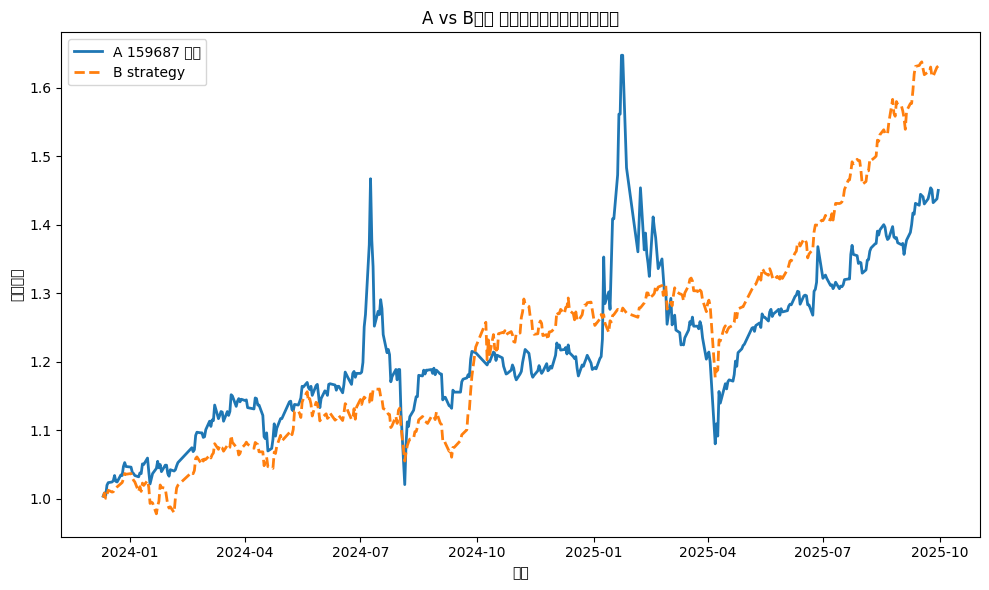


已保存到: ./data/2023-01-01_2025-09-30
- 权重:   ./data/2023-01-01_2025-09-30/weights_159687.csv
- 指标:   ./data/2023-01-01_2025-09-30/metrics_159687.csv
- 曲线:   ./data/2023-01-01_2025-09-30/curves_159687.csv


In [1]:
# -*- coding: utf-8 -*-
# 策略拟合测试（A 用 B 的加权组合去拟合）— 离线版
# 仅从 ./data/{START}_{END}/{code}.csv 读取，不做任何联网下载
# CSV 期望两列：date, close（也兼容首列日期、第二列收盘价的格式）

import warnings, math, os
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========== 1) 在这里自定义 A/B ==========


JSON_A = {"159687": "亚太"}
JSON_B = {
    # 11 （恒生红利） + 3 + 2 + 4 # 不含东南亚
    # 10 + 2.5 * 4 # 含东南亚
    # 40%
    "513880": {"name": "日经225", "weight": 0.125}, 
    "513730": {"name": "东南亚",   "weight": 0.125}, 
    "513310": {"name": "中韩半导体",   "weight": 0.125}, 
    "513630": {"name": "恒生红利", "weight": 0.5}, 
    "159713": {"name": "稀土",   "weight": 0.125},
     # "159545": {"name": "恒生红利低波", "weight": 0.5}, 
    # "513180": {"name": "恒生科技", "weight": 0.2},
    # "512890": {"name": "红利低波",   "weight": 0.20}

}

# # # 按组合曲线中的20%配置 1
# JSON_A = {"159687": "亚太"}
# JSON_B = {
#     # 40%
#     "513880": {"name": "日经225", "weight": 0.18}, # 0.036
#     # "513730": {"name": "东南亚",   "weight": 0.04}, 
#     "513310": {"name": "中韩半导体",   "weight": 0.06}, # 0.012
#     "159545": {"name": "恒生红利低波", "weight": 0.56}, #0.112
#     # 20%
#     "159713": {"name": "稀土",   "weight": 0.2}, # 0.04
#     # 40%
#     # "513180": {"name": "恒生科技", "weight": 0.16},
#     # "512890": {"name": "红利低波",   "weight": 0.4}

# }

# JSON_A = {"159687": "亚太"}
# JSON_B = {
#     "513880": {"name": "日经225",     "weight": 0.45},
#     "513310": {"name": "中韩半导体",   "weight": 0.15},
#     "159545": {"name": "恒生红利低波", "weight": 0.40},
# }

START_DATE = "2023-01-01"
END_DATE   = "2025-09-30"
RISK_FREE_ANNUAL = 0.00
CDAR_ALPHA = 0.95   # CDaR 置信度（95%）

# ========== 2) 工具函数 ==========
def annualize_factor(freq='D'):
    return 252 if freq.upper().startswith('D') else 12

def to_returns(price_series: pd.Series) -> pd.Series:
    return price_series.astype(float).pct_change().dropna()

def to_index(returns: pd.Series, start=1.0) -> pd.Series:
    return start*(1+returns).cumprod()

def _drawdown_series(price_series: pd.Series) -> pd.Series:
    s = price_series.dropna().astype(float)
    return s / s.cummax() - 1.0  # <= 0

def _cdar(drawdowns: pd.Series, alpha: float = 0.95) -> float:
    dd = drawdowns.dropna()
    if dd.empty:
        return np.nan
    q = dd.quantile(1.0 - alpha)   # 取最差(1-alpha)分位
    tail = dd[dd <= q]
    return float(tail.mean()) if not tail.empty else np.nan  # 负数

def compute_metrics(price_series: pd.Series, rf_annual=0.0, freq='D', cdar_alpha: float = 0.95):
    s = price_series.dropna().astype(float)
    rets = s.pct_change().dropna()
    if len(rets) == 0:
        return {"annual_return": np.nan, "sharpe": np.nan, "max_drawdown": np.nan,
                "avg_drawdown": np.nan, "cdar": np.nan}
    af = annualize_factor(freq)
    rf_period = (1+rf_annual)**(1/af) - 1
    excess = rets - rf_period

    ann_ret = (1+rets).prod()**(af/len(rets)) - 1
    sharpe = (excess.mean() / (excess.std(ddof=1) + 1e-12)) * math.sqrt(af)

    dd = _drawdown_series(s)
    max_dd = dd.min()
    avg_dd = dd[dd < 0].mean() if (dd < 0).any() else 0.0
    cdar_v = _cdar(dd, alpha=cdar_alpha)

    return {"annual_return": ann_ret, "sharpe": sharpe, "max_drawdown": max_dd,
            "avg_drawdown": avg_dd, "cdar": cdar_v}

def fmt_pct(x):
    return "NaN" if pd.isna(x) else f"{x*100:.2f}%"

# ========== 3) 离线数据读取 ==========
def _data_folder(start_date: str, end_date: str) -> str:
    return os.path.join(".", "data", f"{start_date}_{end_date}")

def _code_path(folder: str, code: str) -> str:
    return os.path.join(folder, f"{code}.csv")

def _read_one_csv(path: str) -> pd.DataFrame:
    """
    兼容：
      1) date, close
      2) <date_col>, <close_col>
    输出：index=date, col=['close'] 的 DataFrame
    """
    df = pd.read_csv(path)
    # 有显式 'date' 列
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date")
    else:
        # 把第一列当日期
        df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
        df = df.set_index(df.columns[0])

    # 定位收盘列
    if "close" in df.columns:
        close_col = "close"
    else:
        # 尝试大小写/中文匹配
        candidates = [c for c in df.columns if c.lower()=="close" or "收盘" in c]
        if candidates:
            close_col = candidates[0]
        else:
            # 回退：若只有一列则用这列；若多列用第二列
            close_col = df.columns[0] if df.shape[1]==1 else df.columns[1]

    out = df[[close_col]].copy()
    out.columns = ["close"]
    out = out.sort_index()
    return out

def load_etf_prices_offline(codes, start_date, end_date, strict=True) -> pd.DataFrame:
    """
    仅离线读取 ./data/{start}_{end}/{code}.csv。
    strict=True 要求覆盖完整时间段；否则仅裁剪到有数据的区间。
    """
    folder = _data_folder(start_date, end_date)
    if not os.path.isdir(folder):
        raise FileNotFoundError(f"未找到离线目录：{folder}")

    cols = {}
    for code in codes:
        path = _code_path(folder, code)
        if not os.path.isfile(path):
            raise FileNotFoundError(f"未找到离线文件：{path}")
        df = _read_one_csv(path)

        # 裁剪到所需区间
        s = df["close"].copy()
        s = s[(s.index >= pd.to_datetime(start_date)) & (s.index <= pd.to_datetime(end_date))]
        if s.empty:
            raise ValueError(f"{code} 离线文件在区间内无数据：{path}")

        # 覆盖校验
        # if strict:
        #     min_d, max_d = s.index.min(), s.index.max()
        #     if min_d > pd.to_datetime(start_date) or max_d < pd.to_datetime(end_date):
        #         raise ValueError(f"{code} 覆盖不足：[{min_d.date()} ~ {max_d.date()}] 需要 [{start_date} ~ {end_date}] — 请补齐离线CSV")

        cols[code] = s

    prices = pd.DataFrame(cols).sort_index().ffill().dropna(how="all")
    return prices

# ========== 4) 主流程 ==========
def main():
    code_A = list(JSON_A.keys())[0]
    codes_B = list(JSON_B.keys())

    # 仅离线读取
    prices = load_etf_prices_offline([code_A] + codes_B, START_DATE, END_DATE, strict=True)

    # 日收益
    rets = prices.pct_change().dropna()
    ret_A = rets[[code_A]]
    ret_B = rets[codes_B]

    # 权重：若和为1则直接用；否则 NNLS 拟合（离线数据也可拟合，不需要联网）
    weights = np.array([JSON_B[c]["weight"] for c in codes_B])
    if np.isclose(weights.sum(), 1.0):
        print("👉 使用 JSON_B 里配置的权重")
    else:
        print("👉 未配置权重，改用 NNLS 拟合")
        from scipy.optimize import nnls
        df_align = pd.concat([ret_A, ret_B], axis=1).dropna()
        y = df_align.iloc[:, 0].values
        X = df_align.iloc[:, 1:].values
        w, _ = nnls(X, y)
        weights = w / w.sum()

    # 组合收益与指数
    basket_ret = (ret_B * weights).sum(axis=1)
    basket_index = to_index(basket_ret, 1.0)
    A_index = to_index(ret_A.squeeze(), 1.0)

    # 绩效 & 相关性
    corr = float(ret_A.squeeze().corr(basket_ret))
    metrics_A    = compute_metrics(prices[code_A], RISK_FREE_ANNUAL, cdar_alpha=CDAR_ALPHA)
    metrics_Bfit = compute_metrics(basket_index, RISK_FREE_ANNUAL, cdar_alpha=CDAR_ALPHA)

    print("\n=== 权重 ===")
    for c, w in zip(codes_B, weights):
        print(f"{c} {JSON_B[c]['name']}: {w:.4f}")

    print("\n=== 指标（A）===")
    print(f"年化收益: {fmt_pct(metrics_A['annual_return'])}  夏普: {metrics_A['sharpe']:.3f}  "
          f"最大回撤: {fmt_pct(metrics_A['max_drawdown'])}  平均回撤: {fmt_pct(metrics_A['avg_drawdown'])}  "
          f"CDaR[{int(CDAR_ALPHA*100)}%]: {fmt_pct(metrics_A['cdar'])}")

    print("\n=== 指标（B组合）===")
    print(f"年化收益: {fmt_pct(metrics_Bfit['annual_return'])}  夏普: {metrics_Bfit['sharpe']:.3f}  "
          f"最大回撤: {fmt_pct(metrics_Bfit['max_drawdown'])}  平均回撤: {fmt_pct(metrics_Bfit['avg_drawdown'])}  "
          f"CDaR[{int(CDAR_ALPHA*100)}%]: {fmt_pct(metrics_Bfit['cdar'])}")

    print(f"\n相关系数（A vs B组合，日收益）：{corr:.4f}")

    # 绘图
    plt.figure(figsize=(10,6))
    plt.plot(A_index.index, A_index, label=f"A {code_A} {JSON_A[code_A]}", linewidth=2)
    plt.plot(basket_index.index, basket_index, label="B strategy", linewidth=2, linestyle="--")
    plt.title("A vs B组合 累计收益曲线（离线数据）")
    plt.xlabel("日期"); plt.ylabel("累计指数"); plt.legend(); plt.tight_layout(); plt.show()

    # 结果导出到同一 data 文件夹下
    out_folder = _data_folder(START_DATE, END_DATE)
    os.makedirs(out_folder, exist_ok=True)

    weights_df = pd.DataFrame({
        "code": list(codes_B),
        "name": [JSON_B[c]["name"] for c in codes_B],
        "weight": weights
    })
    weights_df.to_csv(os.path.join(out_folder, f"weights_{code_A}.csv"), index=False, encoding="utf-8-sig")

    metrics_df = pd.DataFrame([
        {"系列": f"A: {code_A} {JSON_A[code_A]}",
         "年化收益": fmt_pct(metrics_A["annual_return"]),
         "夏普比率": None if pd.isna(metrics_A["sharpe"]) else round(float(metrics_A["sharpe"]), 3),
         "最大回撤": fmt_pct(metrics_A["max_drawdown"]),
         "平均回撤": fmt_pct(metrics_A["avg_drawdown"]),
         f"CDaR[{int(CDAR_ALPHA*100)}%]": fmt_pct(metrics_A["cdar"])},
        {"系列": "拟合后的B组合",
         "年化收益": fmt_pct(metrics_Bfit["annual_return"]),
         "夏普比率": None if pd.isna(metrics_Bfit["sharpe"]) else round(float(metrics_Bfit["sharpe"]), 3),
         "最大回撤": fmt_pct(metrics_Bfit["max_drawdown"]),
         "平均回撤": fmt_pct(metrics_Bfit["avg_drawdown"]),
         f"CDaR[{int(CDAR_ALPHA*100)}%]": fmt_pct(metrics_Bfit["cdar"])}
    ])
    metrics_df.to_csv(os.path.join(out_folder, f"metrics_{code_A}.csv"), index=False, encoding="utf-8-sig")

    pd.DataFrame({"A_index": A_index, "FittedB_index": basket_index}).to_csv(
        os.path.join(out_folder, f"curves_{code_A}.csv"), encoding="utf-8-sig"
    )

    print(f"\n已保存到: {out_folder}")
    print(f"- 权重:   {os.path.join(out_folder, f'weights_{code_A}.csv')}")
    print(f"- 指标:   {os.path.join(out_folder, f'metrics_{code_A}.csv')}")
    print(f"- 曲线:   {os.path.join(out_folder, f'curves_{code_A}.csv')}")

if __name__ == "__main__":
    main()


In [1]:
# -*- coding: utf-8 -*-
"""
获取 AkShare 中名称包含“红利”的ETF
并计算成立日期、YTD年化收益、夏普比率、CDaR、最大回撤、相对上证的Beta/Alpha
"""

import pandas as pd
import numpy as np
from datetime import date, datetime
import akshare as ak
import math, time

RISK_FREE_ANNUAL = 0.02     # 无风险利率，默认2%
CDAR_ALPHA = 0.95           # CDaR置信度
KEYWORD = "恒生"

# 工具函数
def to_returns(price_series):
    return price_series.astype(float).pct_change().dropna()

def to_index(returns, start=1.0):
    return start*(1+returns).cumprod()

def drawdown_series(price_series):
    s = price_series.dropna().astype(float)
    return s / s.cummax() - 1.0

def cdar(drawdowns, alpha=CDAR_ALPHA):
    dd = drawdowns.dropna()
    if dd.empty: return np.nan
    q = dd.quantile(1.0-alpha)
    tail = dd[dd <= q]
    return abs(tail.mean()) if not tail.empty else np.nan

def compute_metrics(price_series, rf_annual=RISK_FREE_ANNUAL):
    rets = to_returns(price_series)
    if len(rets)==0: 
        return dict(ann_return=np.nan, sharpe=np.nan, mdd=np.nan, cdar=np.nan)
    af = 252
    ann_ret = (1+rets).prod()**(af/len(rets))-1
    rf_daily = (1+rf_annual)**(1/af)-1
    excess = rets - rf_daily
    sharpe = (excess.mean()/(excess.std(ddof=1)+1e-12))*math.sqrt(af)
    dd = drawdown_series(price_series)
    return dict(
        ann_return=ann_ret,
        sharpe=sharpe,
        mdd=dd.min(),
        cdar=cdar(dd, CDAR_ALPHA)
    )

def first_day_and_ytd(code):
    today = date.today()
    year_start = date(today.year,1,1)
    # 获取历史行情
    data = ak.fund_etf_hist_em(symbol=code, period="daily", 
                               start_date="20000101", end_date=today.strftime("%Y%m%d"), adjust="qfq")
    if data is None or data.empty:
        return None,None,None
    df = data.rename(columns={"日期":"date","收盘":"close"})
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date").sort_index()
    first = df.index.min().date().strftime("%Y-%m-%d")
    df_y = df[df.index.date>=year_start]
    if df_y.empty: return first,None,df
    start,end = df_y["close"].iloc[0], df_y["close"].iloc[-1]
    ytd_ret = end/start-1.0
    trading_days = len(df_y)
    ann_ytd = (1+ytd_ret)**(252/trading_days)-1 if trading_days>0 else None
    return first,ann_ytd,df

def fetch_sh_index(start_date):
    today = date.today().strftime("%Y%m%d")
    df = ak.stock_zh_index_daily_em(symbol="sh000001")
    df = df.rename(columns={"close":"close","date":"date"})
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date").sort_index()
    return df[df.index>=pd.to_datetime(start_date)]

def calc_beta_alpha(fund_ret, bench_ret, rf_annual=RISK_FREE_ANNUAL):
    df = pd.concat([fund_ret, bench_ret], axis=1).dropna()
    if df.empty: return np.nan,np.nan
    y,X = df.iloc[:,0].values, df.iloc[:,1].values
    beta = np.cov(y,X)[0,1]/np.var(X)
    alpha = y.mean() - beta*X.mean()
    alpha_ann = alpha*252
    return beta,alpha_ann

def main():
    # ETF列表
    etfs = ak.fund_etf_spot_em()
    etfs = etfs[etfs["名称"].str.contains(KEYWORD)]
    rows=[]
    sh_index = None
    for i,row in etfs.iterrows():
        code,name = row["代码"],row["名称"]
        try:
            first,ann_ytd,df = first_day_and_ytd(code)
            if df is None: continue
            metrics = compute_metrics(df["close"])
            if sh_index is None: sh_index = fetch_sh_index(df.index.min())
            fund_ret = to_returns(df["close"])
            bench_ret = to_returns(sh_index["close"]).reindex(fund_ret.index).dropna()
            fund_ret = fund_ret.loc[bench_ret.index]
            beta,alpha = calc_beta_alpha(fund_ret, bench_ret)
            rows.append({
                "代码":code,"名称":name,"成立日期":first,
                "YTD年化收益":ann_ytd,
                "夏普":metrics["sharpe"],
                "CDaR[95%]":metrics["cdar"],
                "最大回撤":metrics["mdd"],
                "Beta(相对上证)":beta,
                "Alpha(年化)":alpha
            })
        except Exception as e:
            print("⚠️",code,name,"失败",e)
            continue
    result=pd.DataFrame(rows)
    result=result.sort_values("YTD年化收益",ascending=False)
    # 格式化显示
    pretty=result.copy()
    for col in ["YTD年化收益","夏普","CDaR[95%]","最大回撤","Beta(相对上证)","Alpha(年化)"]:
        pretty[col]=pretty[col].apply(lambda x: "" if pd.isna(x) else f"{x:.2%}" if col in ["YTD年化收益","CDaR[95%]","最大回撤","Alpha(年化)"] else f"{x:.3f}")
    print(pretty.to_string(index=False))
    today=datetime.today().strftime("%Y%m%d")
    result.to_csv(f"红利ETF分析_{today}.csv",index=False,encoding="utf-8-sig")
    print("已保存CSV")

if __name__=="__main__":
    main()


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))